# Exploratory Data Analysis
This document contains some information on the exploratory data analysis done.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [17]:
# load dataset
# load dataset
df1 = pd.read_csv("../data/raw/data2016-2025.csv", index_col='date')
df2 = pd.read_csv("../data/raw/data2006-2015.csv", index_col='date')
df3 = pd.read_csv("../data/raw/data1996-2005.csv", index_col='date')
df4 = pd.read_csv("../data/raw/data1986-1995.csv", index_col='date')
df5 = pd.read_csv("../data/raw/data1976-1985.csv", index_col='date')
df = pd.concat([df1,df2, df3, df4, df5]).drop_duplicates()
df = df.sort_index()
pd.set_option("display.max_rows", None)
isna = df.isna().mean()


In [18]:
codes = pd.read_csv("../data/cu-item.tsv", sep="\t", index_col='item_code')

data = []
for col in df.columns:
    na_percent = df[col].isna().mean()
    data.append([col, na_percent, codes.loc[col[8:]].item_name])
pd.DataFrame(data)

,0,1,2
0,CUUR0000SEFA01,0.038591,Flour and prepared flour mixes
1,CUUR0000SEFA02,0.038591,Breakfast cereal
2,CUUR0000SEFA03,0.038591,"Rice, pasta, cornmeal"
3,CUUR0000SEFB01,0.441275,Bread
4,CUUR0000SEFB02,0.441275,"Fresh biscuits, rolls, muffins"
5,CUUR0000SEFB03,0.040268,"Cakes, cupcakes, and cookies"
6,CUUR0000SEFB04,0.040268,Other bakery products
7,CUUR0000SEFC01,0.000000,Uncooked ground beef
8,CUUR0000SEFC02,0.441275,Uncooked beef roasts
9,CUUR0000SEFC03,0.441275,Uncooked beef steaks


In [68]:
def my_grid_plot(df, option='acf'):
    ncols = 3
    nrows = len(df.columns)//3 + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,20))
    axes = axes.flatten() # easier indexing

    i = 0
    for name in df.columns:
        data = df[name].dropna()
        if option=='acf':
            plot_acf(data, ax = axes[i], title=name)
        elif option == 'pacf':
            plot_pacf(data, ax = axes[i], title=name)
        elif option == 'timeseries':
            data = np.log(data)
            data.plot(figsize=(10,10), ax = axes[i], title=name)
            plt.xlabel('Date')
            plt.ylabel('CPI')
        i+=1
    if option == 'timeseries':
        fig.autofmt_xdate()
    plt.tight_layout(h_pad = 3)
    plt.show()

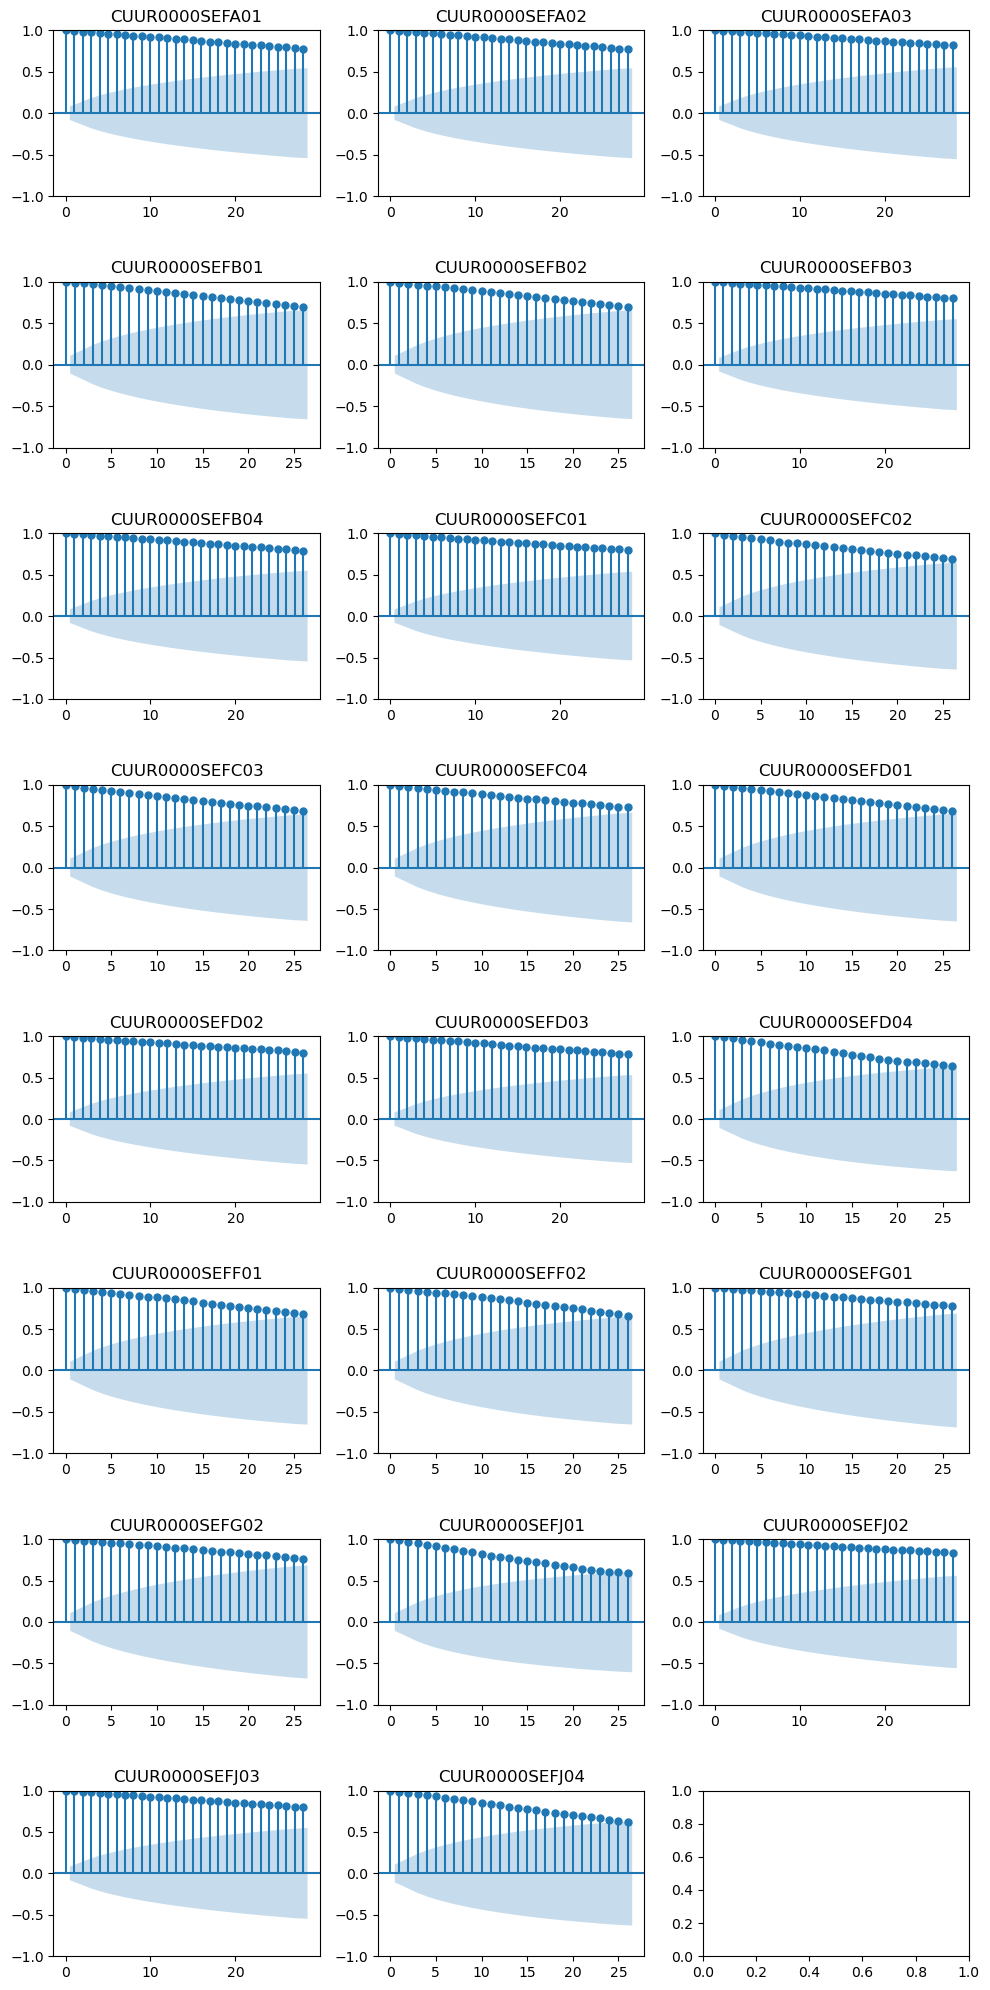

In [69]:
my_grid_plot(df, "acf")

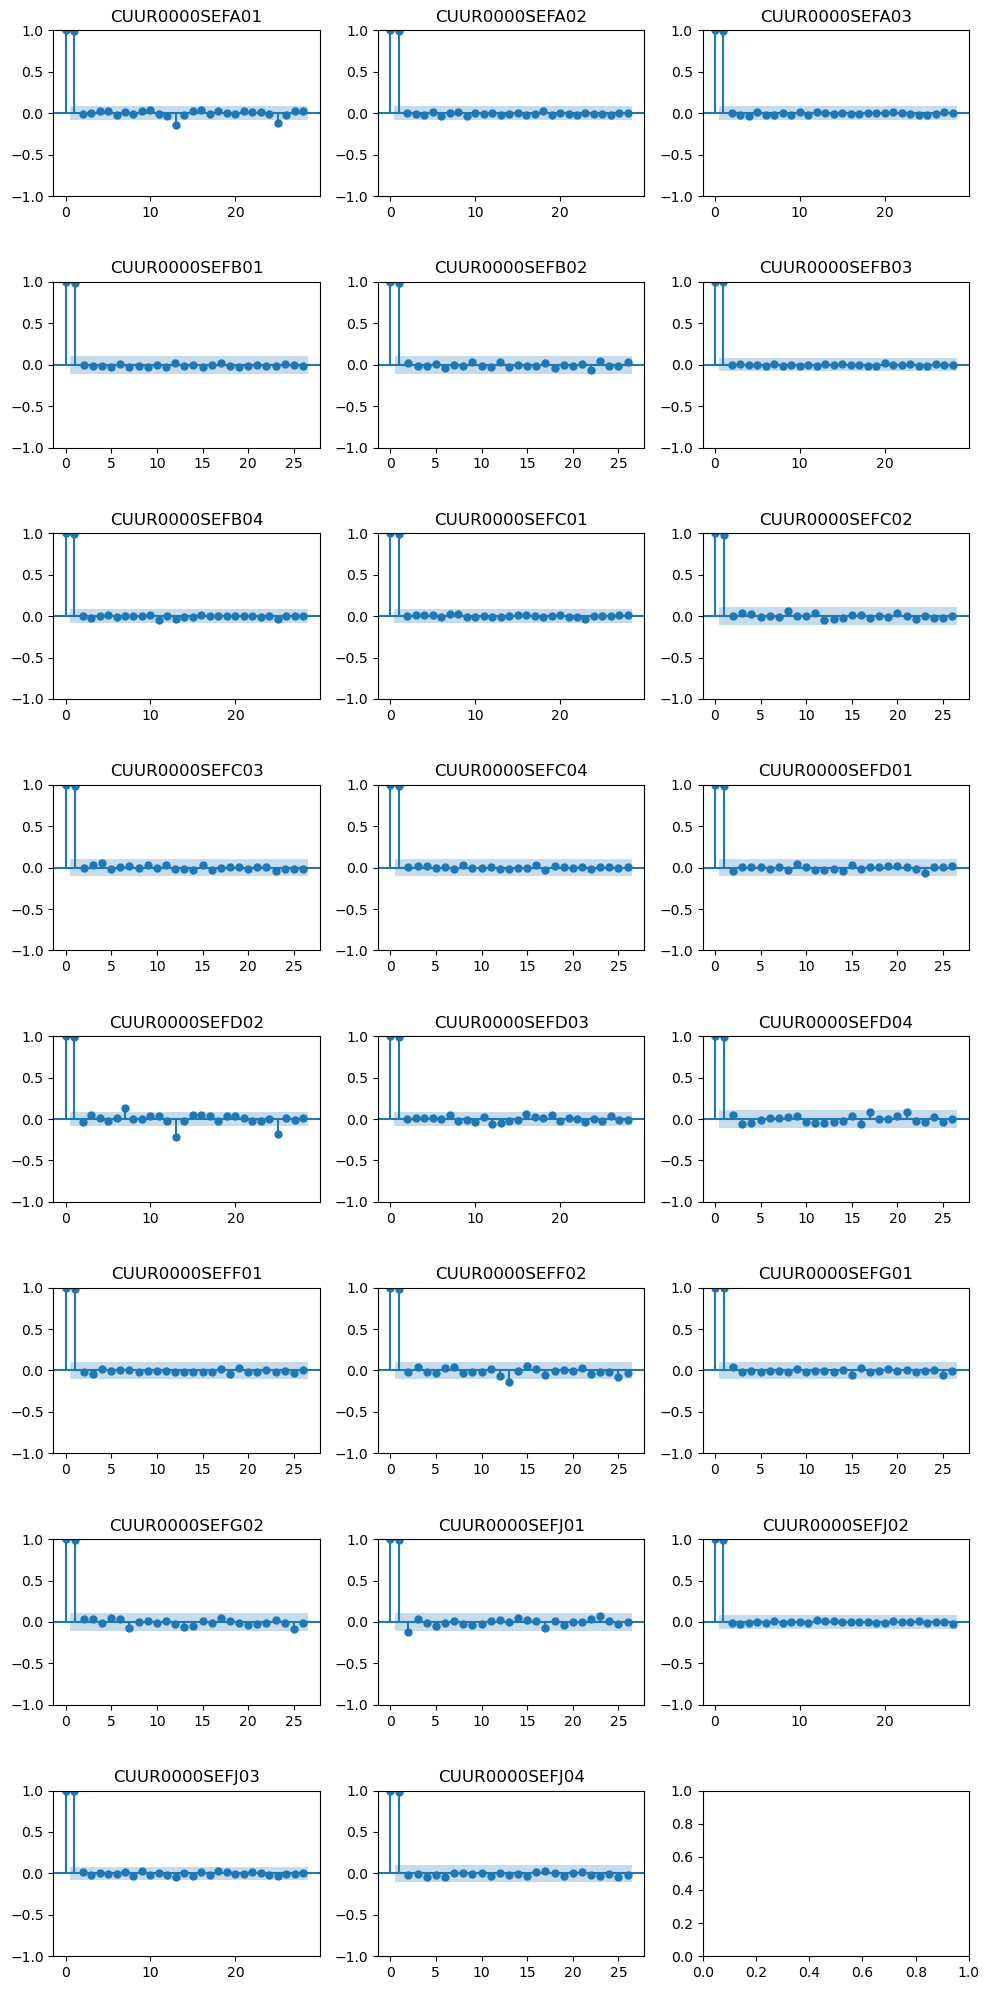

In [70]:
my_grid_plot(df, option='pacf')

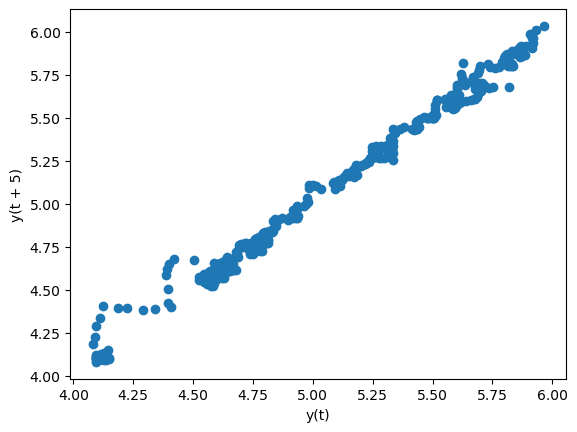

In [78]:
from pandas.plotting import lag_plot
lag_plot(np.log(df['CUUR0000SEFC01']), lag = 5)
#lag_plot(df['CUUR0000SEFC01'], lag = 5)
plt.show()

Loss function should be informed by use of the model.
- baseline 
- consider big life events (e.g. pandemic)
- compare impact on dropping "big events"

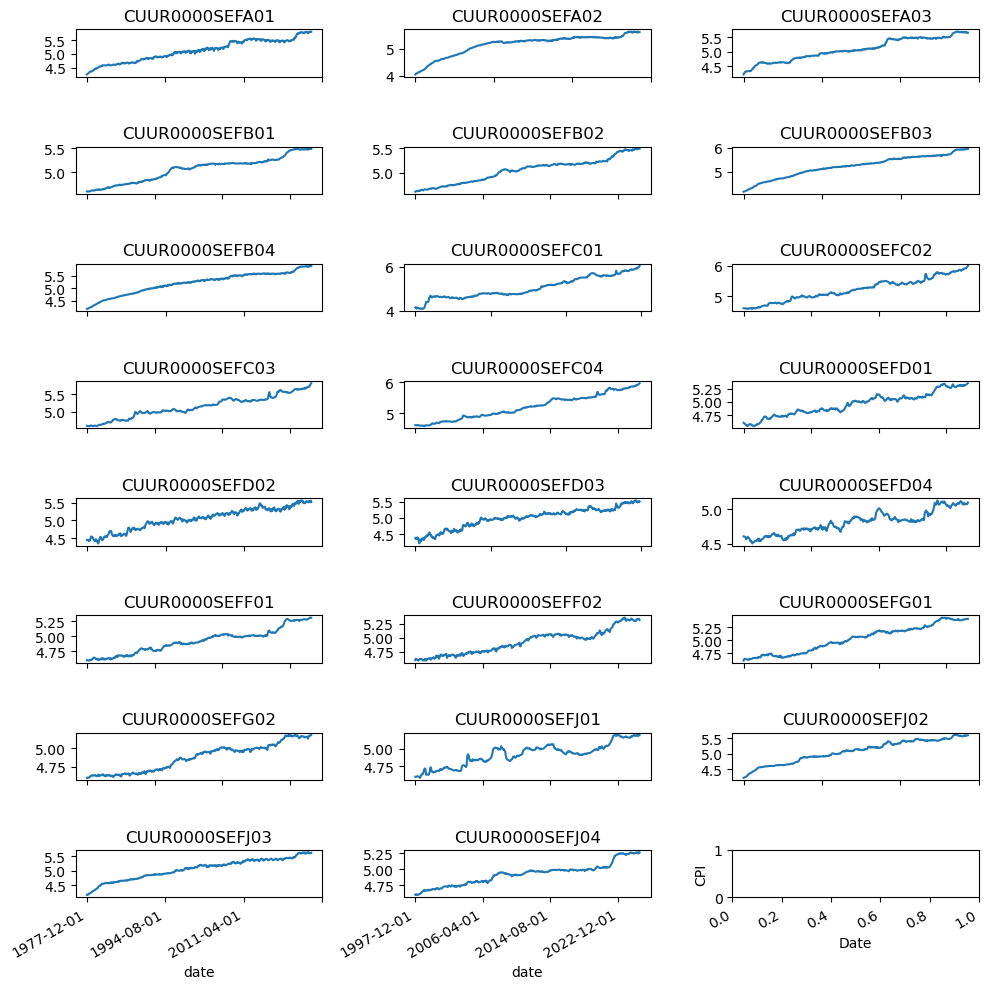

In [72]:
my_grid_plot(df, option="timeseries")
#my_grid_plot(df['CUUR000SEFJ01'], option="timeseries")

In [74]:
np.log(df['CUUR0000SEFJ03'])

date
1976-01-01         NaN
1976-02-01         NaN
1976-03-01         NaN
1976-04-01         NaN
1976-05-01         NaN
1976-06-01         NaN
1976-07-01         NaN
1976-08-01         NaN
1976-09-01         NaN
1976-10-01         NaN
1976-11-01         NaN
1976-12-01         NaN
1977-01-01         NaN
1977-02-01         NaN
1977-03-01         NaN
1977-04-01         NaN
1977-05-01         NaN
1977-06-01         NaN
1977-07-01         NaN
1977-08-01         NaN
1977-09-01         NaN
1977-10-01         NaN
1977-11-01         NaN
1977-12-01    4.175925
1978-01-01    4.169761
1978-02-01    4.182050
1978-03-01    4.185099
1978-04-01    4.197202
1978-05-01    4.222445
1978-06-01    4.223910
1978-07-01    4.222445
1978-08-01    4.229749
1978-09-01    4.238445
1978-10-01    4.252772
1978-11-01    4.265493
1978-12-01    4.269697
1979-01-01    4.287716
1979-02-01    4.295924
1979-03-01    4.301359
1979-04-01    4.309456
1979-05-01    4.317488
1979-06-01    4.332048
1979-07-01    4.333361
1979-0

In [75]:
df['CUUR0000SEFJ03']

date
1976-01-01        NaN
1976-02-01        NaN
1976-03-01        NaN
1976-04-01        NaN
1976-05-01        NaN
1976-06-01        NaN
1976-07-01        NaN
1976-08-01        NaN
1976-09-01        NaN
1976-10-01        NaN
1976-11-01        NaN
1976-12-01        NaN
1977-01-01        NaN
1977-02-01        NaN
1977-03-01        NaN
1977-04-01        NaN
1977-05-01        NaN
1977-06-01        NaN
1977-07-01        NaN
1977-08-01        NaN
1977-09-01        NaN
1977-10-01        NaN
1977-11-01        NaN
1977-12-01     65.100
1978-01-01     64.700
1978-02-01     65.500
1978-03-01     65.700
1978-04-01     66.500
1978-05-01     68.200
1978-06-01     68.300
1978-07-01     68.200
1978-08-01     68.700
1978-09-01     69.300
1978-10-01     70.300
1978-11-01     71.200
1978-12-01     71.500
1979-01-01     72.800
1979-02-01     73.400
1979-03-01     73.800
1979-04-01     74.400
1979-05-01     75.000
1979-06-01     76.100
1979-07-01     76.200
1979-08-01     76.700
1979-09-01     78.200
1979-